In [2]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [3]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [9]:
train_df = pd.read_csv("train_df.csv").sample(frac=.2)
val_df = pd.read_csv("val_df.csv")
path = "../../data/512x512-dataset-melanoma/512x512-dataset-melanoma/"

In [5]:
# set up data loader class 
def relative_scale(img, size=128, focus=1.5):
    # crop image (e.g. focus = 2 cuts image size in half)
    w, h = img[:, :, 0].shape 
    
    x_start = w//2 - np.int(w/(2*focus))
    x_end = w//2 + np.int(w/(2*focus))
    
    y_start = h//2 - np.int(h/(2*focus))
    y_end = h//2 + np.int(h/(2*focus))
    
    img_crop = img[x_start:x_end, y_start:y_end, :]
    
    img_resize = cv2.resize(img, (size, size))
    return img_resize

transform = transforms.Compose(
                   [transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.ToTensor()])
    
    

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]
    
def make_weights_for_balanced_classes(df, nclasses=2):   
    targets = df["target"].values
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[label] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[label]                                  
    return weight  

In [7]:
# Hyper parameters
num_epochs = 1
batch_size = 64
learning_rate = 0.001

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=2, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=4, stride=4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=4, stride=4)) 
        self.fc = nn.Sequential(
            nn.Linear(1800, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(p=0.5))
        self.output = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.output(out)
        return out

model = ConvNet().to(device)
model.load_state_dict(torch.load('../Models/model.ckpt'), strict=False)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# Use the data loader.
train_dataset = Dataset(train_df, path)
train_weights = make_weights_for_balanced_classes(train_df)
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, len(train_weights))                                                
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           sampler = train_sampler)   

# evaluate performance on validation data 
valid_dataset = Dataset(val_df, path)
valid_weights = make_weights_for_balanced_classes(val_df)
valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(valid_weights, len(valid_weights))                                                
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=50, 
                                           sampler = valid_sampler) 

# save losses from training 
losses = []
val_roc = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # set up model for training 
        model = model.train()
        
        images = images.to(device)
        
        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # store loss
        losses.append(loss)
        
        # Calculate ROC
        predictions = outputs.detach().cpu().numpy().ravel()
        targets = labels.cpu().numpy().ravel()

        fpr, tpr, _ = roc_curve(np.array(targets, np.int), np.array(predictions).ravel())
        train_roc_auc = auc(fpr, tpr)
        
        # prep model for evaluation
        valid_predictions = []
        valid_targets = []
        model.eval() 
        with torch.no_grad():
            for j, (images, labels) in enumerate(valid_loader):
                images = images.to(device)

                labels = torch.reshape(labels, [len(labels), 1])
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate val ROC
                valid_predictions += list(outputs.detach().cpu().numpy().ravel())
                valid_targets += list(labels.cpu().numpy().ravel()) 

        fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
        val_roc_auc = auc(fpr, tpr)
        val_roc.append(val_roc_auc)
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train ROC AUC: {:.4f}, Val ROC AUC: {:.4f}' 
               .format(epoch+1, num_epochs, i+1, total_step, loss.item(), train_roc_auc, val_roc_auc))

Epoch [1/1], Step [1/94], Loss: 0.6433, Train ROC AUC: 0.7328, Val ROC AUC: 0.8534
Epoch [1/1], Step [2/94], Loss: 0.4600, Train ROC AUC: 0.8688, Val ROC AUC: 0.8589
Epoch [1/1], Step [3/94], Loss: 0.5132, Train ROC AUC: 0.8198, Val ROC AUC: 0.8721
Epoch [1/1], Step [4/94], Loss: 0.5409, Train ROC AUC: 0.7875, Val ROC AUC: 0.8830
Epoch [1/1], Step [5/94], Loss: 0.5125, Train ROC AUC: 0.8099, Val ROC AUC: 0.8633
Epoch [1/1], Step [6/94], Loss: 0.4725, Train ROC AUC: 0.8539, Val ROC AUC: 0.8831
Epoch [1/1], Step [7/94], Loss: 0.6190, Train ROC AUC: 0.7530, Val ROC AUC: 0.8520
Epoch [1/1], Step [8/94], Loss: 0.5308, Train ROC AUC: 0.8187, Val ROC AUC: 0.8922
Epoch [1/1], Step [9/94], Loss: 0.4846, Train ROC AUC: 0.8308, Val ROC AUC: 0.8491
Epoch [1/1], Step [10/94], Loss: 0.5429, Train ROC AUC: 0.8075, Val ROC AUC: 0.8743
Epoch [1/1], Step [11/94], Loss: 0.5727, Train ROC AUC: 0.7823, Val ROC AUC: 0.8890
Epoch [1/1], Step [12/94], Loss: 0.5746, Train ROC AUC: 0.7848, Val ROC AUC: 0.8643
E

TypeError: Cannot handle this data type

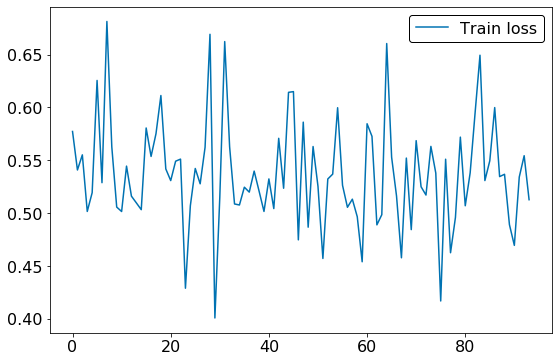

In [18]:
plt.figure(figsize=(9,6))
plt.plot(losses,label='Train loss')
#plt.ylim([.4, .8])
plt.legend()
plt.show()

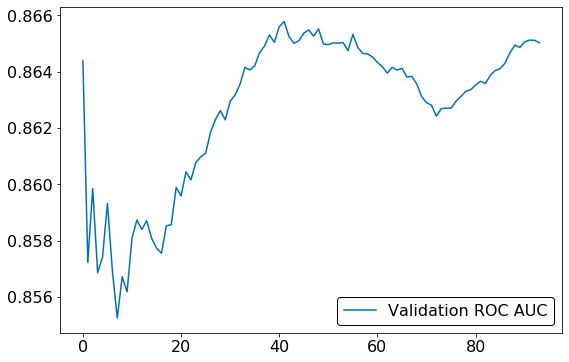

In [19]:
plt.figure(figsize=(9,6))
plt.plot(val_roc,label='Validation ROC AUC')
plt.legend()
plt.show()


Baseline classification accuracy: 91.07

Model classification accuracy:    0.92


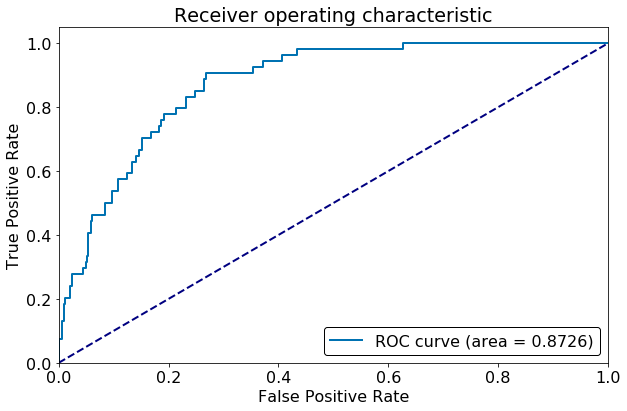

In [8]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

valid_predictions = []
valid_targets = []

valid_dataset = Dataset(val_df, path)                                             
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=50, 
                                           shuffle=False) 

model.eval() # prep model for evaluation
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)

        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        valid_predictions += list(outputs.detach().cpu().numpy().ravel())
        valid_targets += list(labels.cpu().numpy().ravel()) 

fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
roc_auc = auc(fpr, tpr)

percent_tp = sum(valid_targets)/len(valid_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])
acc = np.sum(np.round(valid_predictions) == np.array(valid_targets)) / len(valid_targets)

print('\nBaseline classification accuracy: {:.2f}'.format(baseline))
print('\nModel classification accuracy:    {:.2f}'.format(acc))

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [18]:
confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel()))

array([[551,   0],
       [ 50,   4]], dtype=int64)

In [21]:
if roc_auc > .87:
    torch.save(model.state_dict(), '../Models/model.ckpt')